# <span style="color:red">QPM: Assignment 6</span>

###  LAFTIT Mehdi, LIN Christine, MUSEUX Célia and YANG Hexuan 

Financial Engineering - Quantitative Portfolio Management

**Due date :** 20/11/2023 9am


## <span style="color:green">Preliminary step</span>

We import the libraries we are going to use in this assignment:

In [207]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from tabulate import tabulate

### STEP 1: we  build a dataframe with the prices for the 6 stocks

we can download the prices from Yahoo Finance

In [208]:
symbols = ["AAPL", "MSFT", "AMZN", "NVDA", "TSLA", "META"]

So our universe is: AAPL, MSFT, AMZN, NVDA, TSLA and META

In [209]:
stock_prices = (yf.download(tickers=symbols, 
                            start="2015-01-01",
                            end="2022-12-31",
                            progress=False)
  .melt(ignore_index=False, 
        var_name=["variable", "symbol"])
  .reset_index()
  .pivot(index=["Date", "symbol"], 
         columns="variable", 
         values="value")
  .reset_index()
  .rename(columns = {"Date": "date", 
                     "Open": "open", 
                     "High": "high", 
                     "Low": "low",
                     "Close": "close", 
                     "Adj Close": "adjusted", 
                     "Volume": "volume"
                    })
)

In [210]:
stock_prices.head()

variable,date,symbol,adjusted,close,high,low,open,volume
0,2015-01-02,AAPL,24.466450,27.332500,27.860001,26.837500,27.847500,212818400.0
1,2015-01-02,AMZN,15.426000,15.426000,15.737500,15.348000,15.629000,55664000.0
2,2015-01-02,META,78.449997,78.449997,78.930000,77.699997,78.580002,18177500.0
3,2015-01-02,MSFT,40.452740,46.759998,47.419998,46.540001,46.660000,27913900.0
4,2015-01-02,NVDA,4.833230,5.032500,5.070000,4.952500,5.032500,11368000.0


We drop the columns that have only “NaN” entries.

In [211]:
new_stock_prices = stock_prices.dropna(axis=1, how='all')

In [212]:
new_stock_prices.head()

variable,date,symbol,adjusted,close,high,low,open,volume
0,2015-01-02,AAPL,24.466450,27.332500,27.860001,26.837500,27.847500,212818400.0
1,2015-01-02,AMZN,15.426000,15.426000,15.737500,15.348000,15.629000,55664000.0
2,2015-01-02,META,78.449997,78.449997,78.930000,77.699997,78.580002,18177500.0
3,2015-01-02,MSFT,40.452740,46.759998,47.419998,46.540001,46.660000,27913900.0
4,2015-01-02,NVDA,4.833230,5.032500,5.070000,4.952500,5.032500,11368000.0


We can plot the 6 stock prices

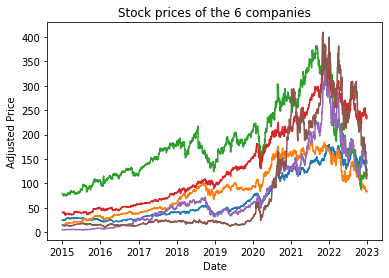

In [213]:
symbols_to_plot = new_stock_prices['symbol'].unique()[:6]
filtered_data = new_stock_prices[new_stock_prices['symbol'].isin(symbols_to_plot)]

fig, ax = plt.subplots()
for symbol, data in filtered_data.groupby('symbol'):
    ax.plot(data['date'], data['adjusted'], label=symbol)

ax.set_title("Stock prices of the 6 companies")
ax.set_xlabel("Date")
ax.set_ylabel("Adjusted Price")
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.legend().set_visible(False)

plt.show()

### STEP 2: we compute their monthly excess returns starting January 2015 and ending December 2022

We now compute the monthly log-returns using the following formula:  $ln(Pt/P(t-1))$ where $ln$ is the natural logarithm function and $Pt$ is the adjusted prices at time t.

In [214]:
new_stock_prices['date'] = pd.to_datetime(new_stock_prices['date'])
new_stock_prices.set_index('date', inplace=True)

log_return_matrix = (new_stock_prices
    .pivot(columns="symbol", values="adjusted")
    .resample("M")
    .last()
    .apply(lambda x: np.log(x / x.shift(1)))
    .dropna()
)

In [215]:
log_return_matrix.head()

symbol,AAPL,AMZN,META,MSFT,NVDA,TSLA
date,,,,,,
2015-02-28,0.096016,0.069799,0.039520,0.089037,0.142699,-0.001278
2015-03-31,-0.031874,-0.021430,0.040331,-0.075530,-0.052583,-0.074350
2015-04-30,0.005770,0.125321,-0.042866,0.179201,0.058909,0.180227
2015-05-31,0.044341,0.017509,0.005318,-0.030804,0.001460,0.103900
2015-06-30,-0.037938,0.011259,0.079819,-0.059572,-0.095717,0.067301


Because risk-free rate is 0, the excess returns are log returns themselves.

In [216]:
excess_return = log_return_matrix

### STEP 3: we use the “Index Weighting” to assign the market weights for these assets

We divide each index weighting by sum of weight to make sure the total weight of the portfolio is 1

In [217]:
# Index weighting from investopedia
index_weighting = {'AAPL': 0.071, 'AMZN': 0.0324, 'META': 0.0184, 'MSFT': 0.0651,'NVDA': 0.0284, 'TSLA': 0.0187}

#We assign market weights to the assets and round to 4 decimals
sum_of_weights = sum(index_weighting.values())
weights=[]

print("\033[1mMarket weights:\033[0m ")

for symbol in index_weighting:
    weight = round(index_weighting.get(symbol, 0) / sum_of_weights, 4)  
    weights.append(weight)
    print(f"{symbol}: {weight}")

Market weights: 
AAPL: 0.3034
AMZN: 0.1385
META: 0.0786
MSFT: 0.2782
NVDA: 0.1214
TSLA: 0.0799


## <span style="color:green">Question 1 of Assignment 6</span>

Based on the sample data, we are going to compute the Markowitz portfolio weights.

In [218]:
mu_sample = excess_return.mean() 
cov = excess_return.cov()
inv_cov = np.linalg.inv(cov)

We compute the risk aversion gamma: 

In [219]:
global_return = (mu_sample * weights).sum()
weights_array = np.array(weights)
var = np.matmul(weights_array.T, np.matmul(cov.values, weights_array))
print(f'The global mean return is {global_return:.4f} and the variance is {var:.6}')

gamma = global_return / var
print("\033[1m\nThe risk aversion parameter is\033[0m ",gamma)

The global mean return is 0.0196 and the variance is 0.00515565

The risk aversion parameter is  3.8072139537612415


We compute the markowitz weights. We have decided to make the sum of the weights equal to 1. The formula is: $w = (1/gamma) * inv(V[R]) * (E[R] - Rf1n)$. But here Rf = 0

In [220]:
markowitz_weights = (1/gamma) * np.dot(inv_cov, mu_sample)
sum_of_weights = np.sum(markowitz_weights)
markowitz_weights = markowitz_weights / sum_of_weights

print("\033[1mMarkowitz_weights:\033[0m ")
for i, weight in enumerate(markowitz_weights):
    print(f"Stock {i + 1}: {weight:.6f}")

Markowitz_weights: 
Stock 1: -0.095060
Stock 2: -0.216609
Stock 3: -0.272536
Stock 4: 1.280829
Stock 5: 0.267140
Stock 6: 0.036237


When it is negative, it means we have to sell the stock.

## <span style="color:green">Question 2 of Assignment 6</span>

Using the market-capitalization weights, we have to obtain the CAPM-implied expected returns. The formula is:
$E[Rcapm] -Rf1n = w * Gamma * V[R]$.

In [221]:
def implied_rets(risk_aversion, sigma, w):
    implied_rets = risk_aversion * sigma @ w
    return implied_rets

mu_capm = implied_rets(gamma, cov, weights)
print("\033[1mCAPM-implied expected returns:\033[0m ")
mu_capm

CAPM-implied expected returns: 


symbol
AAPL    0.019794
AMZN    0.019368
META    0.015023
MSFT    0.014297
NVDA    0.028142
TSLA    0.029615
dtype: float64

## <span style="color:green">Question 3 of Assignment 6</span>

We are going to specify the pick matrix P and the view vector q that captures the following views for each of the assets

- AAPL: its absolute excess return is expected to be 10% per year.
- MSFT: its absolute excess return is expected to be 5% per year.
- NVDA will outperform TSLA by 2% per year.
- TSLA will underperform META by 1% per year.

So we have 4 views for 6 assets.

Finally, we will explain our choice for the matrix Ω, which captures the uncertainty about these views.

In [222]:
q = np.array([0.1, 0.05, 0.02, 0.01])

In [223]:
P = np.asarray([[1, 0, 0, 0, 0, 0],
                [0, 0, 0, 1, 0, 0],
                [0, 0, 0, 0, 1, -1],
                [0, 0, 1, 0, 0, -1]])

**Explanation**: 

Each view has a corresponding row in the picking matrix (the order matters). Because there are 4 views, there are 4 rows. Absolute views have a single 1 in the column corresponding to the ticker’s order in the universe. Relative views have a positive number in the nominally outperforming asset columns and a negative number in the nominally underperforming asset columns.

We compute the matrix omega: we use $ τ * P * Σ * P^T$ to determine the omega matrix 

In [224]:
#We use 2015-2022 year to estimate the return moments. Therefore, we have 8 years * 12 months = 96 data points
tau = 1/96

In [225]:
def omega_matrix(sigma, tau, P):
    matrix = np.diag(np.diag(tau*P@sigma@P.T))
    return matrix


omega = omega_matrix(cov, tau, P).round(6)

print("\033[1mOmega:\033[0m ")
omega

Omega: 


array([[7.20e-05, 0.00e+00, 0.00e+00, 0.00e+00],
       [0.00e+00, 4.00e-05, 0.00e+00, 0.00e+00],
       [0.00e+00, 0.00e+00, 3.20e-04, 0.00e+00],
       [0.00e+00, 0.00e+00, 0.00e+00, 2.98e-04]])

**Explanation of Omega matrix** =  it represents the estimates of variance of the error in the views, that is to say the uncertainty or confidence in the views . So here we have 4 views, so we have four diagonal elements which represent the variance of the error of each view.

The larger the diagonal elements, the higher the confidence in the corresponding views. Also, we know that the choice of $τ$ and the construction of Omega matrix involve a subjective judgment, and different choices can lead to different portfolio outcomes.

## <span style="color:green">Question 4 of Assignment 6</span>

We use these views to compute the conditional expected excess return and conditional covariance matrix of excess returns $µ$BL and $Σ$BL.

### Step 1 : we compute 𝐶[µ,𝑞]

We calculate $C[µ, q]$:
c = $C[µ, q] = (τ*Σ)*P^T$

In [227]:
c = tau * cov @ (P.T)

### Step 2: we compute E[µ|𝑞] and V[µ|𝑞]

we get the conditional expectation of µ:  mu_BL = $E[µ|q]= µcapm + c*inv(P*c+omega)*(q -P*µcapm)$

In [228]:
# Calculate the BL Return Vector
mu_BL = mu_capm + c @ np.linalg.inv((P@c)+ omega) @ (q - (P@mu_capm))

In [229]:
print("\033[1mMu_BL:\033[0m ")
mu_BL

Mu_BL: 


symbol
AAPL    0.062301
AMZN    0.048895
META    0.043817
MSFT    0.040357
NVDA    0.075002
TSLA    0.058232
dtype: float64

the conditional variance of µ: cov_BL = $V[µ|q]= (τ*Σ) - c* inv(P*c + omega) * P*(τ*Σ)$

In [230]:
cov_BL1 = (tau * cov) - c @ np.linalg.inv((P@c) + omega) @ (P @ (tau* cov))

In [231]:
print("\033[1mcov_BL:\033[0m ")
cov_BL1

cov_BL: 


symbol,AAPL,AMZN,META,MSFT,NVDA,TSLA
symbol,,,,,,
AAPL,0.000031,0.000014,0.000014,0.000009,0.000025,0.000024
AMZN,0.000014,0.000059,0.000026,0.000016,0.000035,0.000032
META,0.000014,0.000026,0.000078,0.000012,0.000025,0.000039
MSFT,0.000009,0.000016,0.000012,0.000018,0.000019,0.000016
NVDA,0.000025,0.000035,0.000025,0.000019,0.000112,0.000050
TSLA,0.000024,0.000032,0.000039,0.000016,0.000050,0.000125


### Step 3: we compute E[𝑅|𝑞] and V[𝑅|𝑞]

We now need to find $E[R|q]$ and $V[R|q]$

We have:
- $E[R|q] = E[µ|q]$
- $V[R|q] = V[µ|q] + Ver$

In [232]:
cov_BL= cov_BL1 + cov
cov_BL

symbol,AAPL,AMZN,META,MSFT,NVDA,TSLA
symbol,,,,,,
AAPL,0.006986,0.004080,0.003188,0.003259,0.006535,0.007306
AMZN,0.004080,0.008149,0.004107,0.003813,0.006826,0.006688
META,0.003188,0.004107,0.009719,0.002788,0.004466,0.004402
MSFT,0.003259,0.003813,0.002788,0.003842,0.005075,0.004366
NVDA,0.006535,0.006826,0.004466,0.005075,0.017728,0.007334
TSLA,0.007306,0.006688,0.004402,0.004366,0.007334,0.027785


## <span style="color:green">Question 5 of Assignment 6</span>

we now have to use $µ$BL and $Σ$BL to compute the mean-variance weights and compare them with the weights from the CAPM and the weights based on sample moments.


The the Black-Litterman portfolio weights are given by: $w = (1/gamma) * inv(𝑉[𝑅|𝑞]) * 𝐸[𝑅|𝑞]$. Here again we made the decision to make the sum of weights equal to 1

In [233]:
BL_weight = (1/gamma)*np.linalg.inv(cov_BL)@mu_BL
BL_weight = BL_weight/np.sum(BL_weight)

In [234]:
print("\033[1mBL_weight:\033[0m ")
BL_weight

BL_weight: 


array([ 0.5609859 ,  0.04450213,  0.09729162,  0.3045759 ,  0.0481184 ,
       -0.05547395])

In [235]:
returns_table = pd.concat([mu_sample, mu_capm, mu_BL], axis=1) * 100
returns_table.columns = ['Markowitz', 'CAPM', 'BL']
returns_table['Difference BL - CAPM'] = returns_table['BL'] - returns_table['CAPM']
returns_table['Difference BL - Markowitz'] = returns_table['BL'] - returns_table['Markowitz']


returns_table_formatted = returns_table.round(2).applymap('{:,.2f}%'.format)
table_format = 'fancy_grid'
column_alignment = ['center'] * len(returns_table.columns)
print("\033[1mComparison of returns\033[0m ")
print(tabulate(returns_table_formatted, headers='keys', tablefmt=table_format, showindex=True, colalign=column_alignment))

Comparison of returns 
╒══════════╤═════════════╤════════╤═══════╤════════════════════════╤═════════════════════════════╕
│  symbol  │  Markowitz  │  CAPM  │  BL   │  Difference BL - CAPM  │ Difference BL - Markowitz   │
╞══════════╪═════════════╪════════╪═══════╪════════════════════════╪═════════════════════════════╡
│   AAPL   │    1.68%    │ 1.98%  │ 6.23% │         4.25%          │ 4.55%                       │
├──────────┼─────────────┼────────┼───────┼────────────────────────┼─────────────────────────────┤
│   AMZN   │    1.64%    │ 1.94%  │ 4.89% │         2.95%          │ 3.25%                       │
├──────────┼─────────────┼────────┼───────┼────────────────────────┼─────────────────────────────┤
│   META   │    0.49%    │ 1.50%  │ 4.38% │         2.88%          │ 3.90%                       │
├──────────┼─────────────┼────────┼───────┼────────────────────────┼─────────────────────────────┤
│   MSFT   │    2.02%    │ 1.43%  │ 4.04% │         2.61%          │ 2.02%            

We can see that the Black litterman model perform better out of sample compare to the CAPM and the markovitz portfolio.

We can now compare the weights: the Capital Asset Pricing Model (CAPM) says that every investor should hold the same portfolio of risky assets, this common portfolio then must be the market portfolio.
So the CAPM weights are the market weights.

In [236]:
capm_weights = np.array(weights)
markowitz_weights = np.array(markowitz_weights)
BL_weight = np.array(BL_weight)
symbols = ["AAPL", "MSFT", "AMZN", "NVDA", "TSLA", "META"]


weights_table = pd.DataFrame({'Markowitz': markowitz_weights, 'CAPM (market)': capm_weights, 'Black-Litterman': BL_weight}, index=symbols) * 100
weights_table.loc['Total'] = weights_table.sum()
weights_table_formatted = weights_table.round(2).applymap('{:,.2f}%'.format)
table_format = 'fancy_grid'
column_alignment = ['center'] * len(weights_table.columns)

print("\033[1mComparison of weights\033[0m ")
print(tabulate(weights_table_formatted, headers='keys', tablefmt=table_format, showindex=True, colalign=column_alignment))

Comparison of weights 
╒═══════╤═════════════╤═════════════════╤═══════════════════╕
│       │  Markowitz  │  CAPM (market)  │ Black-Litterman   │
╞═══════╪═════════════╪═════════════════╪═══════════════════╡
│ AAPL  │   -9.51%    │     30.34%      │ 56.10%            │
├───────┼─────────────┼─────────────────┼───────────────────┤
│ MSFT  │   -21.66%   │     13.85%      │ 4.45%             │
├───────┼─────────────┼─────────────────┼───────────────────┤
│ AMZN  │   -27.25%   │      7.86%      │ 9.73%             │
├───────┼─────────────┼─────────────────┼───────────────────┤
│ NVDA  │   128.08%   │     27.82%      │ 30.46%            │
├───────┼─────────────┼─────────────────┼───────────────────┤
│ TSLA  │   26.71%    │     12.14%      │ 4.81%             │
├───────┼─────────────┼─────────────────┼───────────────────┤
│ META  │    3.62%    │      7.99%      │ -5.55%            │
├───────┼─────────────┼─────────────────┼───────────────────┤
│ Total │   100.00%   │     100.00%     │ 100.0